In [1]:
import serial
import numpy as np
from KeysightScope import KeysightScope
from IPython.display import Image, display

PORT = 'COM7'

MHZ = 1e6

SAVE_IMAGES = False
SHOW_IMAGES = True

Scope class to taking test images

In [2]:
my_instrument = KeysightScope()

In [3]:
my_instrument.write(":CHANnel1:DISPlay 1")
my_instrument.write(':ChANnel1:SCALe +2E+00')
my_instrument.write(':ChANnel1:OFFSet -4E+00')
my_instrument.write(":TRIGger:EDGE:SOURce CHANnel1")

my_instrument.write(":CHANnel2:DISPlay 1")
my_instrument.write(':ChANnel2:SCALe +2.00E+00')
my_instrument.write(':ChANnel2:OFFSet 0.0')

my_instrument.write(":CHANnel3:DISPlay 1")
my_instrument.write(':ChANnel3:SCALe +2.00E+00')
my_instrument.write(':ChANnel3:OFFSet +4.0E+00')

my_instrument.write(":CHANnel4:DISPlay 1")
my_instrument.write(':ChANnel4:SCALe +2.00E+00')
my_instrument.write(':ChANnel4:OFFSet +7.5E+00')

27

Define pico comms

In [4]:
# convenience send command for one-off sends

def send(command: str, echo = True, PORT = PORT) -> str:
    # pico expecting a newline termination for each command

    if command[-1] != '\n':
        command += '\n'

    resp = ''
    conn = None
    try:
        conn = serial.Serial(PORT, baudrate = 152000, timeout = 0.1)
        conn.write(command.encode())
        if echo:
            resp = conn.readlines()
            resp = "".join(s.decode() for s in resp)
    except Exception as e:
        print(f'Encountered Error: {e}')
    
    finally:
        conn.close()

    return resp

In [5]:
print(send('ver'))
print(send('sts'))

Version: 1.3.1

run-status:0 clock-status:0



Enable debug output for command validation. Not generally needed.

In [6]:
print(send('deb'))

ok



## Manual output toggling

beginning state:  0

ok
Output commanded: 1

new state:  1

ok
Output commanded: f

new state:  f

ok
Output commanded: 3

new state:  3

ok
Output commanded: 2

new state:  2

ok
Output commanded: 0

final state:  0



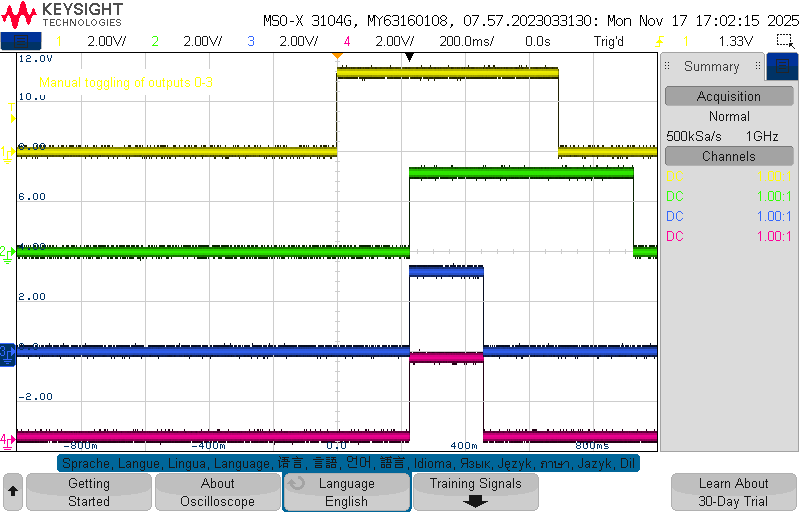

In [ ]:
my_instrument.annotate_screen("Manual toggling of outputs 0-3")
my_instrument.set_time_scale(200e-3)


print('beginning state: ', send('gto'))
print(send('man 1'))
print('new state: ', send('gto'))
print(send('man f'))
print('new state: ', send('gto'))
print(send('man 3'))
print('new state: ', send('gto'))
print(send('man 2'))
print('new state: ', send('gto'))
print(send('man 0'))
print('final state: ', send('gto'))

if SHOW_IMAGES:
    buf = my_instrument.get_screenshot()
    display(Image(data=buf))
elif SAVE_IMAGES:
    fname = 'manual_toggling_test.png'
    my_instrument.save_screenshot(fname)

## `set` program write

In [8]:
couplets = 4
for i in range(0, couplets*2, 2):
    print(send(f'set {i:d} f a'))
    print(send(f'set {i+1:d} 0 a'))

print(send(f'set {i+2:d} 0 0'))
print(send(f'set {i+3:d} 0 0'))

NumNZ: 2, Arr Idx: 0, Output: f, Reps: 6
ok

NumNZ: 4, Arr Idx: 2, Output: 0, Reps: 6
ok

NumNZ: 6, Arr Idx: 4, Output: f, Reps: 6
ok

NumNZ: 8, Arr Idx: 6, Output: 0, Reps: 6
ok

NumNZ: a, Arr Idx: 8, Output: f, Reps: 6
ok

NumNZ: c, Arr Idx: a, Output: 0, Reps: 6
ok

NumNZ: e, Arr Idx: c, Output: f, Reps: 6
ok

NumNZ: 10, Arr Idx: e, Output: 0, Reps: 6
ok

NumNZ: 12, Arr Idx: 10, Output: 0, Reps: 0
ok

NumNZ: 14, Arr Idx: 12, Output: 0, Reps: 0
ok



In [9]:
print(send('dmp'))

do_cmd: 000f
	reps: a
do_cmd: 0000
	reps: a
do_cmd: 000f
	reps: a
do_cmd: 0000
	reps: a
do_cmd: 000f
	reps: a
do_cmd: 0000
	reps: a
do_cmd: 000f
	reps: a
do_cmd: 0000
	reps: a
do_cmd: 0000
	Wait
do_cmd: 0000
	Wait



ok
hwstart: 0
Tight execution loop ended
Program ended at instr 16
Execution stopped
Core1 loop ended

run-status:0 clock-status:0



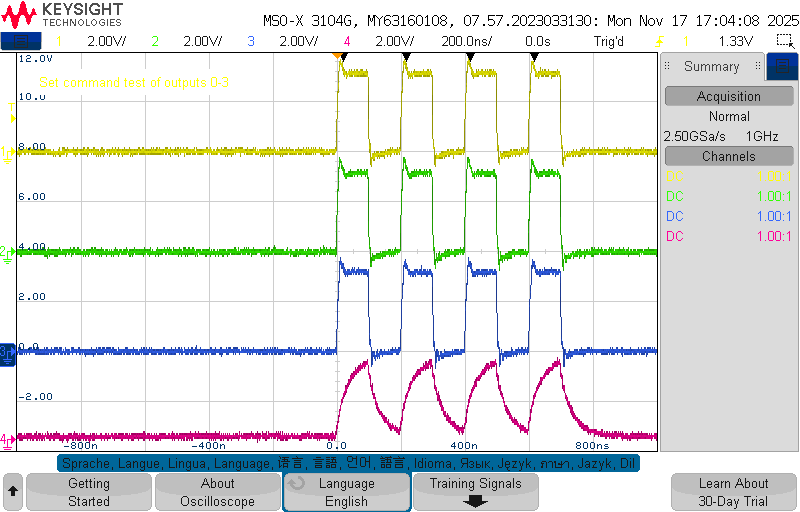

In [ ]:
my_instrument.annotate_screen("Set command test of outputs 0-3")
my_instrument.set_time_scale(200e-9)

print(send('swr'))
print(send('sts'))

if SHOW_IMAGES:
    buf = my_instrument.get_screenshot()
    display(Image(data=buf))
elif SAVE_IMAGES:
    fname = 'set_program_test.png'
    my_instrument.save_screenshot(fname)

## Bulk binary program write

In [13]:
do = serial.Serial(PORT, baudrate=152000, timeout=0.1)

bits = [1, 2, 3, 8, 10, 20, 0, 0]
cycles = [100, 100, 100, 100, 100, 100, 0, 0]

data = np.zeros(len(bits), dtype=[('bits', 'u2'), ('cycles','u4')])
data['bits'] = bits
data['cycles'] = cycles

serial_buffer = data.tobytes()

do.write(f'adm 0 {len(data):x}\r\n'.encode())
resp = do.readline().decode()
assert resp == 'ready\r\n', f'Not ready for binary data. Response was {repr(resp)}'
do.write(serial_buffer)
resp = do.readline().decode()
if resp != 'ok\r\n':
  # if response not ok, probably more than one line, read them all
  # done this way to prevent readlines timeout for standard operation
  extra_resp = do.readlines()
  resp += ''.join([st.decode() for st in extra_resp])
  print(f'Write had errors. Response was {repr(resp)}')

do.close()

In [14]:
print(send('dmp'))
print(send('len'))

do_cmd: 0001
	reps: 64
do_cmd: 0002
	reps: 64
do_cmd: 0003
	reps: 64
do_cmd: 0008
	reps: 64
do_cmd: 000a
	reps: 64
do_cmd: 0014
	reps: 64
do_cmd: 0000
	Wait
do_cmd: 0000
	Wait

Number of command lines: 16
Number of instructions: 8



ok
hwstart: 0
Tight execution loop ended
Program ended at instr 16
Execution stopped
Core1 loop ended

run-status:0 clock-status:0



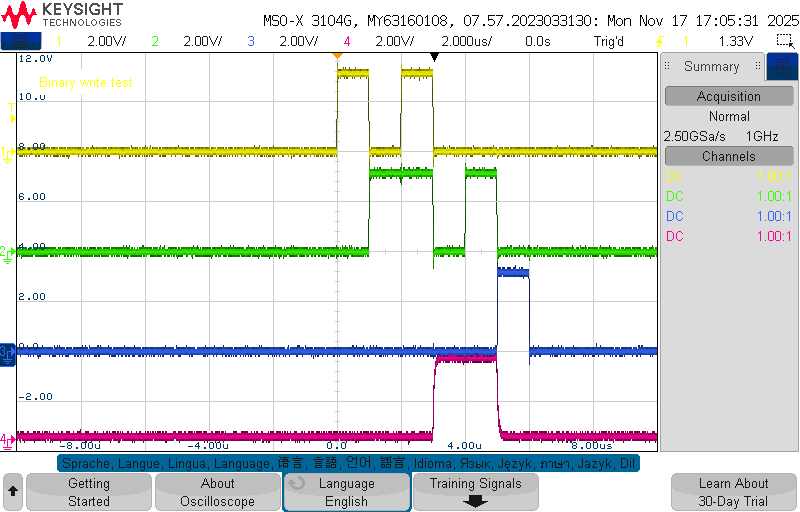

In [ ]:
my_instrument.annotate_screen("Binary write test")
my_instrument.set_time_scale(2e-6)

print(send('swr'))
print(send('sts'))

if SHOW_IMAGES:
    buf = my_instrument.get_screenshot()
    display(Image(data=buf))
elif SAVE_IMAGES:
    fname = 'binary_program_test.png'
    my_instrument.save_screenshot(fname)